In [17]:
import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold._utils import _binary_search_perplexity
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

In [2]:
def _joint_probabilities(distances, desired_perplexity):
    distances = distances.astype(np.float32, copy=False)
    conditional_P = _binary_search_perplexity(
        distances, None, desired_perplexity, False)
    P = conditional_P + conditional_P.T
    sum_P = np.maximum(np.sum(P), MACHINE_EPSILON)
    P = np.maximum(squareform(P) / sum_P, MACHINE_EPSILON)
    return P

In [3]:
MACHINE_EPSILON = np.finfo(np.double).eps
n_components = 2
perplexity = 30

In [4]:
def fit(X):
    n_samples = X.shape[0]
    
    distances = pairwise_distances(X, metric='euclidean', squared=True)
    
    P = _joint_probabilities(distances, perplexity)
    
    X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)
    
    degrees_of_freedom = max(n_components - 1, 1)
    
    return _tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded)

In [5]:
def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components):
    X_embedded = params.reshape(n_samples, n_components)
    
    dist = pdist(X_embedded, "sqeuclidean")
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)
    
    kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    
    PQd = squareform((P - Q) * dist)
    
    for i in range(n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                         X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c

    return kl_divergence, grad

In [6]:
def _tsne(P, degrees_of_freedom, n_samples, X_embedded):

    params = X_embedded.ravel()
    
    obj_func = _kl_divergence
    
    params = _gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, n_components])
        
    X_embedded = params.reshape(n_samples, n_components)

    return X_embedded

In [11]:
def _gradient_descent(obj_func, p0, args, it=0, n_iter=1000,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7):
    
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it
    
    for i in range(it, n_iter):

        error, grad = obj_func(p, *args)

        grad_norm = linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      " (%s iterations in %0.3fs)"
                      % (i + 1, error, grad_norm)
        
        if error < best_error:
                best_error = error
                best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        
        if grad_norm <= min_grad_norm:
            break

    return p

In [12]:
X, y = load_digits(return_X_y=True)

In [13]:
W_projections = fit(X)

[t-SNE] Iteration 0 error = 4.022967653535623 gradient norm = 4.934765456710011e-06
[t-SNE] Iteration 1 error = 4.022967649711132 gradient norm = 4.90090269522625e-06
[t-SNE] Iteration 2 error = 4.022967641642291 gradient norm = 5.881255674466956e-06
[t-SNE] Iteration 3 error = 4.022967623963442 gradient norm = 8.89975854079239e-06
[t-SNE] Iteration 4 error = 4.02296757406135 gradient norm = 1.4971239579608664e-05
[t-SNE] Iteration 5 error = 4.022967409259115 gradient norm = 2.6973591957357712e-05
[t-SNE] Iteration 6 error = 4.022966798653295 gradient norm = 5.1761595386778936e-05
[t-SNE] Iteration 7 error = 4.022964276467773 gradient norm = 0.00010523721721256152
[t-SNE] Iteration 8 error = 4.022952717916669 gradient norm = 0.00022567792620975524
[t-SNE] Iteration 9 error = 4.022894283432323 gradient norm = 0.0005084456061013043
[t-SNE] Iteration 10 error = 4.022570478873522 gradient norm = 0.0011980504496023059
[t-SNE] Iteration 11 error = 4.020625405631327 gradient norm = 0.00292123

[t-SNE] Iteration 99 error = 1.0083573577188267 gradient norm = 0.0005226522334851325
[t-SNE] Iteration 100 error = 1.0058722710527555 gradient norm = 0.0005303482757881284
[t-SNE] Iteration 101 error = 1.0034138531306753 gradient norm = 0.0005247964872978628
[t-SNE] Iteration 102 error = 1.00096385594017 gradient norm = 0.0005135349929332733
[t-SNE] Iteration 103 error = 0.998519750614508 gradient norm = 0.0005172244855202734
[t-SNE] Iteration 104 error = 0.996087567105131 gradient norm = 0.0004946928238496184
[t-SNE] Iteration 105 error = 0.9936917380499722 gradient norm = 0.0004963147803209722
[t-SNE] Iteration 106 error = 0.9913224853082918 gradient norm = 0.0004968752036802471
[t-SNE] Iteration 107 error = 0.9889719818715001 gradient norm = 0.0004674875526688993
[t-SNE] Iteration 108 error = 0.9866478615034713 gradient norm = 0.0004889636766165495
[t-SNE] Iteration 109 error = 0.9843314819521795 gradient norm = 0.0005089363548904657
[t-SNE] Iteration 110 error = 0.9820082346734186

[t-SNE] Iteration 195 error = 0.8629414305408006 gradient norm = 0.0003337585658300668
[t-SNE] Iteration 196 error = 0.8614567900652048 gradient norm = 0.00034561313805170357
[t-SNE] Iteration 197 error = 0.8598835489418968 gradient norm = 0.00036974920658394694
[t-SNE] Iteration 198 error = 0.8582236371923215 gradient norm = 0.00038694951217621565
[t-SNE] Iteration 199 error = 0.8564956558688924 gradient norm = 0.0003886241465806961
[t-SNE] Iteration 200 error = 0.8547369177051369 gradient norm = 0.00041321650496684015
[t-SNE] Iteration 201 error = 0.852974301232604 gradient norm = 0.0004553801263682544
[t-SNE] Iteration 202 error = 0.8513255593978818 gradient norm = 0.0004783742770086974
[t-SNE] Iteration 203 error = 0.8499841806499004 gradient norm = 0.0005473897326737642
[t-SNE] Iteration 204 error = 0.8488253270426496 gradient norm = 0.0005925952573306859
[t-SNE] Iteration 205 error = 0.8477061360060635 gradient norm = 0.0005865895072929561
[t-SNE] Iteration 206 error = 0.84663870

[t-SNE] Iteration 291 error = 0.8063169773370362 gradient norm = 0.000279557250905782
[t-SNE] Iteration 292 error = 0.8059640313582228 gradient norm = 0.0002745782840065658
[t-SNE] Iteration 293 error = 0.805662770166071 gradient norm = 0.00029445032123476267
[t-SNE] Iteration 294 error = 0.805427074604524 gradient norm = 0.00032050968729890883
[t-SNE] Iteration 295 error = 0.8051211507017296 gradient norm = 0.0002705860824789852
[t-SNE] Iteration 296 error = 0.8048555164153091 gradient norm = 0.0002515312808100134
[t-SNE] Iteration 297 error = 0.8045831227132777 gradient norm = 0.0002292920689797029
[t-SNE] Iteration 298 error = 0.8042991780917342 gradient norm = 0.00019193050684407353
[t-SNE] Iteration 299 error = 0.8040361722763143 gradient norm = 0.00019400293240323663
[t-SNE] Iteration 300 error = 0.8037942367824857 gradient norm = 0.00021430985361803323
[t-SNE] Iteration 301 error = 0.8035463247237662 gradient norm = 0.00021275867766235024
[t-SNE] Iteration 302 error = 0.80328935

[t-SNE] Iteration 387 error = 0.7847757127779278 gradient norm = 0.00013382821634877473
[t-SNE] Iteration 388 error = 0.7845502911603922 gradient norm = 0.00017755605222191662
[t-SNE] Iteration 389 error = 0.7843217081857403 gradient norm = 0.00014727406960446388
[t-SNE] Iteration 390 error = 0.7840936088867838 gradient norm = 0.0001557919313199818
[t-SNE] Iteration 391 error = 0.78386335248556 gradient norm = 0.00015390515909530222
[t-SNE] Iteration 392 error = 0.7836322772429878 gradient norm = 0.00014171325892675668
[t-SNE] Iteration 393 error = 0.783401706426231 gradient norm = 0.00015482799790333956
[t-SNE] Iteration 394 error = 0.7831689554652934 gradient norm = 0.00013537198537960649
[t-SNE] Iteration 395 error = 0.7829369100368146 gradient norm = 0.00015159242320805788
[t-SNE] Iteration 396 error = 0.7827033958604377 gradient norm = 0.00014539375843014568
[t-SNE] Iteration 397 error = 0.7824696434813377 gradient norm = 0.00014642468886449933
[t-SNE] Iteration 398 error = 0.7822

[t-SNE] Iteration 481 error = 0.7604521328505882 gradient norm = 0.00014695970457978547
[t-SNE] Iteration 482 error = 0.7602113003941267 gradient norm = 0.00013563234824687243
[t-SNE] Iteration 483 error = 0.7599745662563097 gradient norm = 0.0001341217284789309
[t-SNE] Iteration 484 error = 0.759741491817745 gradient norm = 0.0001394675491610542
[t-SNE] Iteration 485 error = 0.7595116008358729 gradient norm = 0.000136459173518233
[t-SNE] Iteration 486 error = 0.7592853328831444 gradient norm = 0.00013273449440021068
[t-SNE] Iteration 487 error = 0.7590621304951237 gradient norm = 0.00013138710346538574
[t-SNE] Iteration 488 error = 0.7588419552520194 gradient norm = 0.00012587656965479255
[t-SNE] Iteration 489 error = 0.7586254448645738 gradient norm = 0.00012754995259456336
[t-SNE] Iteration 490 error = 0.758411985590277 gradient norm = 0.00012694703764282167
[t-SNE] Iteration 491 error = 0.7582015322811075 gradient norm = 0.00012936063285451382
[t-SNE] Iteration 492 error = 0.757995

[t-SNE] Iteration 576 error = 0.7459740676902307 gradient norm = 0.00012063056055922061
[t-SNE] Iteration 577 error = 0.7458566649792009 gradient norm = 0.00010273910447722301
[t-SNE] Iteration 578 error = 0.7457396492073498 gradient norm = 0.00010201850818702951
[t-SNE] Iteration 579 error = 0.7456212116792377 gradient norm = 9.809523180592805e-05
[t-SNE] Iteration 580 error = 0.745491062817213 gradient norm = 0.00011569652269827202
[t-SNE] Iteration 581 error = 0.7453557391839669 gradient norm = 0.00013867176312487572
[t-SNE] Iteration 582 error = 0.7452474574938983 gradient norm = 0.00014810716675128788
[t-SNE] Iteration 583 error = 0.7451093289780597 gradient norm = 0.00011703909694915637
[t-SNE] Iteration 584 error = 0.7450011064551766 gradient norm = 0.0001316576381213963
[t-SNE] Iteration 585 error = 0.7448888728700603 gradient norm = 0.00012206551764393225
[t-SNE] Iteration 586 error = 0.7447816247097185 gradient norm = 0.00012211500143166631
[t-SNE] Iteration 587 error = 0.744

[t-SNE] Iteration 671 error = 0.7355756096599855 gradient norm = 8.674406126374379e-05
[t-SNE] Iteration 672 error = 0.735472701913771 gradient norm = 8.577116386732087e-05
[t-SNE] Iteration 673 error = 0.7353712438534319 gradient norm = 8.699294994585216e-05
[t-SNE] Iteration 674 error = 0.7352710977976086 gradient norm = 8.256635919678956e-05
[t-SNE] Iteration 675 error = 0.7351720912467041 gradient norm = 8.121623250190169e-05
[t-SNE] Iteration 676 error = 0.735074327056318 gradient norm = 8.307605457957834e-05
[t-SNE] Iteration 677 error = 0.7349775520782063 gradient norm = 8.433162292931229e-05
[t-SNE] Iteration 678 error = 0.7348815752445239 gradient norm = 8.298920874949545e-05
[t-SNE] Iteration 679 error = 0.7347864447869537 gradient norm = 8.165978215401992e-05
[t-SNE] Iteration 680 error = 0.7346922106355092 gradient norm = 8.095736848190427e-05
[t-SNE] Iteration 681 error = 0.7345987325678527 gradient norm = 7.889978587627411e-05
[t-SNE] Iteration 682 error = 0.7345058240733

[t-SNE] Iteration 768 error = 0.7257521028448555 gradient norm = 8.650681411381811e-05
[t-SNE] Iteration 769 error = 0.7256196708390398 gradient norm = 9.146637603407726e-05
[t-SNE] Iteration 770 error = 0.7254868819208362 gradient norm = 9.016477997647598e-05
[t-SNE] Iteration 771 error = 0.7253548721461343 gradient norm = 9.47639491641894e-05
[t-SNE] Iteration 772 error = 0.7252228238612297 gradient norm = 9.063800098374486e-05
[t-SNE] Iteration 773 error = 0.7250911051178945 gradient norm = 8.85418921825476e-05
[t-SNE] Iteration 774 error = 0.7249600880210084 gradient norm = 8.82979657035321e-05
[t-SNE] Iteration 775 error = 0.7248297197631759 gradient norm = 8.660722232889384e-05
[t-SNE] Iteration 776 error = 0.7247000682077671 gradient norm = 8.285618241643533e-05
[t-SNE] Iteration 777 error = 0.7245713979182766 gradient norm = 8.669219823786989e-05
[t-SNE] Iteration 778 error = 0.7244434911169552 gradient norm = 8.296652958961204e-05
[t-SNE] Iteration 779 error = 0.72431665563849

[t-SNE] Iteration 864 error = 0.7169112074052055 gradient norm = 7.242521678563207e-05
[t-SNE] Iteration 865 error = 0.7168407577153331 gradient norm = 7.732007361482829e-05
[t-SNE] Iteration 866 error = 0.716770324687819 gradient norm = 8.1364341895096e-05
[t-SNE] Iteration 867 error = 0.7166995491347439 gradient norm = 7.480204658349976e-05
[t-SNE] Iteration 868 error = 0.7166290701821868 gradient norm = 7.793294207658619e-05
[t-SNE] Iteration 869 error = 0.7165589098183519 gradient norm = 8.443918341072276e-05
[t-SNE] Iteration 870 error = 0.716488315048043 gradient norm = 8.041868568398058e-05
[t-SNE] Iteration 871 error = 0.7164177757691443 gradient norm = 7.19664603821002e-05
[t-SNE] Iteration 872 error = 0.7163477718384701 gradient norm = 7.73047431721352e-05
[t-SNE] Iteration 873 error = 0.7162773615680909 gradient norm = 7.459696644218639e-05
[t-SNE] Iteration 874 error = 0.7162070520977757 gradient norm = 7.164015551097691e-05
[t-SNE] Iteration 875 error = 0.7161367785426 gra

[t-SNE] Iteration 960 error = 0.7102262931822104 gradient norm = 6.110515823820606e-05
[t-SNE] Iteration 961 error = 0.710183857799677 gradient norm = 5.860441524419002e-05
[t-SNE] Iteration 962 error = 0.7101415731326794 gradient norm = 5.6114895414793864e-05
[t-SNE] Iteration 963 error = 0.7100995691282389 gradient norm = 5.9451045672176406e-05
[t-SNE] Iteration 964 error = 0.710057520227205 gradient norm = 5.8998019085265696e-05
[t-SNE] Iteration 965 error = 0.710015536991913 gradient norm = 5.6343997130170465e-05
[t-SNE] Iteration 966 error = 0.7099736951587934 gradient norm = 5.5653537856414914e-05
[t-SNE] Iteration 967 error = 0.7099319317229906 gradient norm = 5.665554272127338e-05
[t-SNE] Iteration 968 error = 0.7098901730113332 gradient norm = 5.5018477723933756e-05
[t-SNE] Iteration 969 error = 0.709848495908156 gradient norm = 5.419720764621161e-05
[t-SNE] Iteration 970 error = 0.7098068368928504 gradient norm = 5.195614357944578e-05
[t-SNE] Iteration 971 error = 0.709765237

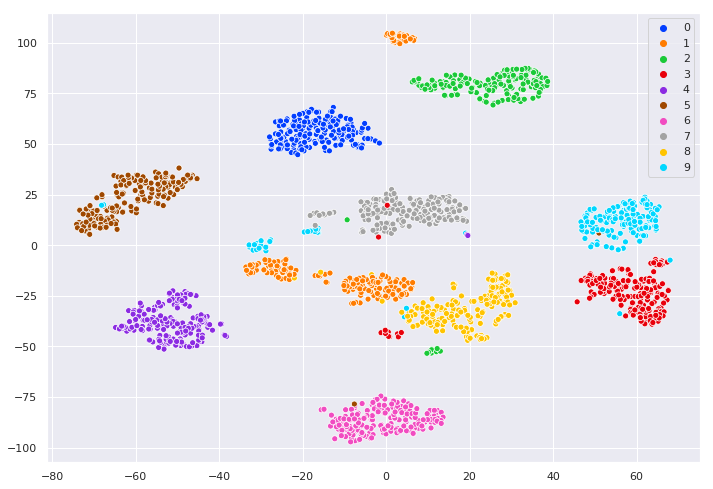

In [18]:
palette = sns.color_palette("bright", 10)

sns.scatterplot(W_projections[:,0], W_projections[:,1], hue=y, legend='full', palette=palette)

In [16]:
tsne = TSNE()

In [ ]:
X_projection = tsne.fit_transform(X)

In [ ]:


sns.scatterplot(X_projection[:,0], X_projection[:,1], hue=y, legend='full', palette=palette)

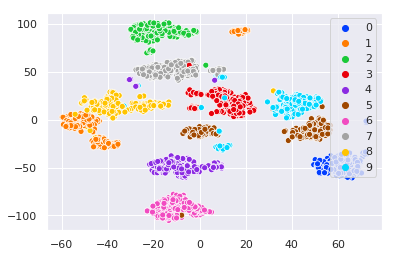